In [1]:
import os
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pandeia.engine.calc_utils import build_default_calc, build_default_source
from skimage import restoration
from lenstronomy.Data.psf import PSF
from astropy import convolution
from skimage import restoration

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleSkyPyLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, lenstronomy_sim, pandeia_input, convert, bkg, psf

drawback: sky background is being convolved with on-axis PSF but image is off-axis PSF

# 1. generate image with Pandeia with no background or noise

In [2]:
band = 'f106'
lens = SampleSkyPyLens()
# add CDM subhalos; NB same subhalo population for all
lens.add_subhalos(*pyhalo.unpickle_subhalos(os.path.join(pickle_dir, 'pyhalo', 'cdm_subhalos_tuple')))
model = lens.get_array(num_pix=51 * 3, side=5.61)

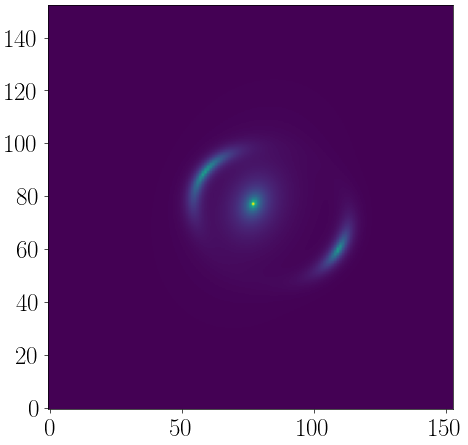

In [3]:
plot.plot(model)

In [4]:
calc, _ = pandeia_input.build_pandeia_calc(model, lens, background=False, band=band, max_scene_size=5, noise=False, num_samples=1000, suppress_output=False)

pandeia_none, _ = pandeia_input.get_pandeia_image(calc)

  4%|▍         | 34/791 [00:00<00:04, 158.76it/s]

100%|██████████| 791/791 [00:04<00:00, 163.55it/s]


Point source conversion complete: placed 791 point sources
Estimated calculation time: 0:01:02
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:57


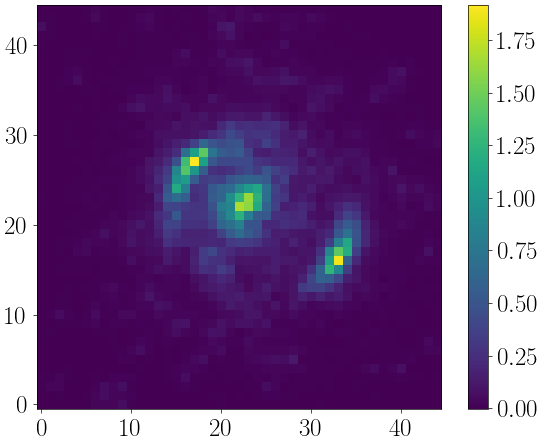

In [5]:
plot.plot(pandeia_none, colorbar=True)

# 2. generate another image with everything on

In [6]:
calc, _ = pandeia_input.build_pandeia_calc(model, lens, background=True, band=band, max_scene_size=5, noise=True, num_samples=1000, suppress_output=False)

pandeia_on, _ = pandeia_input.get_pandeia_image(calc)

  0%|          | 0/153 [00:00<?, ?it/s]

100%|██████████| 820/820 [00:04<00:00, 169.85it/s]


Point source conversion complete: placed 820 point sources
Estimated calculation time: 0:01:04
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:57


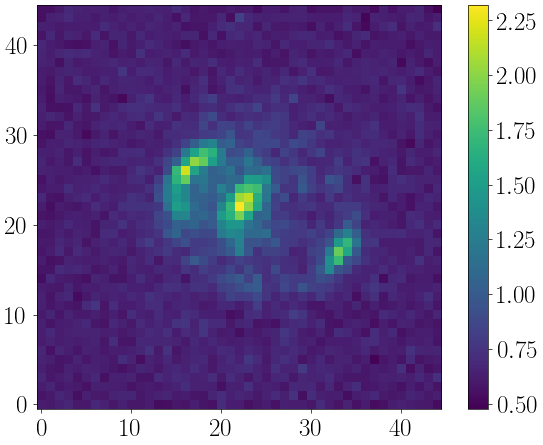

In [7]:
plot.plot(pandeia_on, colorbar=True)

# 3. substract to get convolved background and detector noise

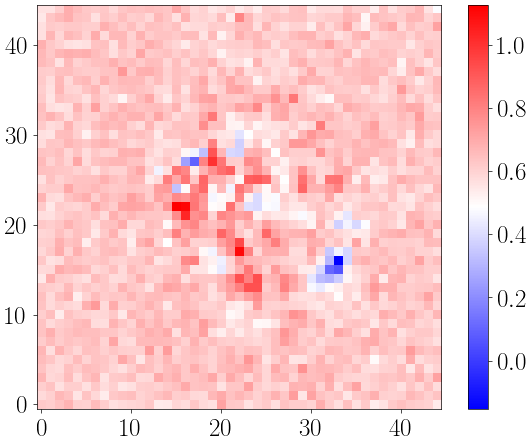

In [8]:
convolved_bkg_and_noise = pandeia_on - pandeia_none

plot.plot(convolved_bkg_and_noise, colorbar=True, cmap='bwr')

# 4. deconvolve the "nothing on" image to get synthetic image in Pandeia units

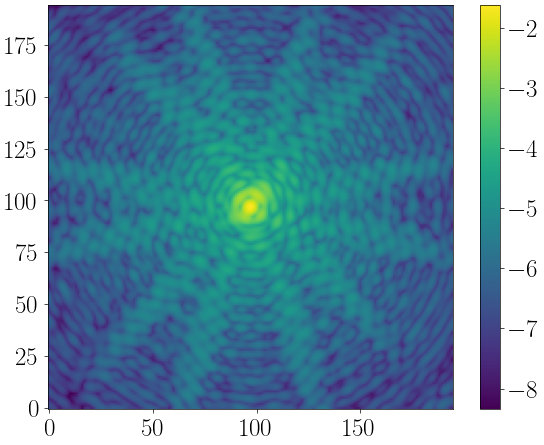

In [9]:
pandeia_kernel = psf.load_psf(os.path.join(os.environ['pandeia_refdata'], 'roman', 'wfi', 'psfs', 'wfi_imaging-f062-f087-f106-f129-f146-f158_1.0465.fits'))
plot.log10(pandeia_kernel, colorbar=True)

In [10]:
deconvolved = pandeia_none  # TODO fix

# 5. convolve this image with off-axis PSF

Detector: SCA05
Detector position: 1500, 2907


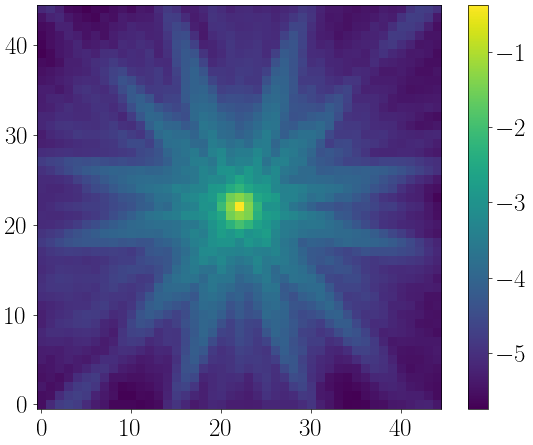

In [11]:
off_axis_oversample = 5
off_axis_kernel = psf.get_random_psf_kernel(band=band, oversample=off_axis_oversample, suppress_output=False)
plot.log10(off_axis_kernel, colorbar=True)

In [12]:
off_axis_image = convolution.convolve(deconvolved, off_axis_kernel)

# 6. add off-axis image with background and noise

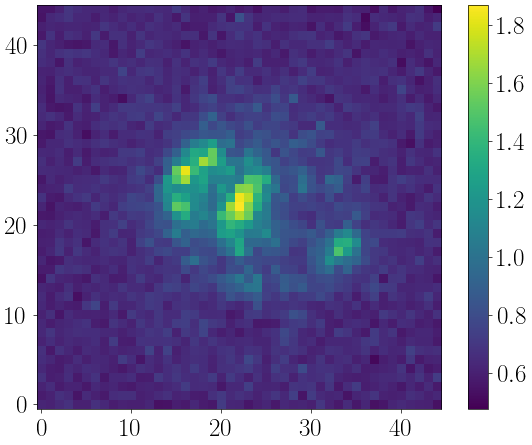

In [13]:
final_image = off_axis_image + convolved_bkg_and_noise

plot.plot(final_image, colorbar=True)